In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

# 00 (1), 01 (2), 10 (3) либо 11 (4)
DIGIT_TO_ENCODE = 1

# Версия с семинара

Надо сделать квантовый регистр на 4 кубита:
- #1, #2 для кодирвания числа от 0 до 3
- #3 транспортный от Алисы к Бобу
- #4 у Боба

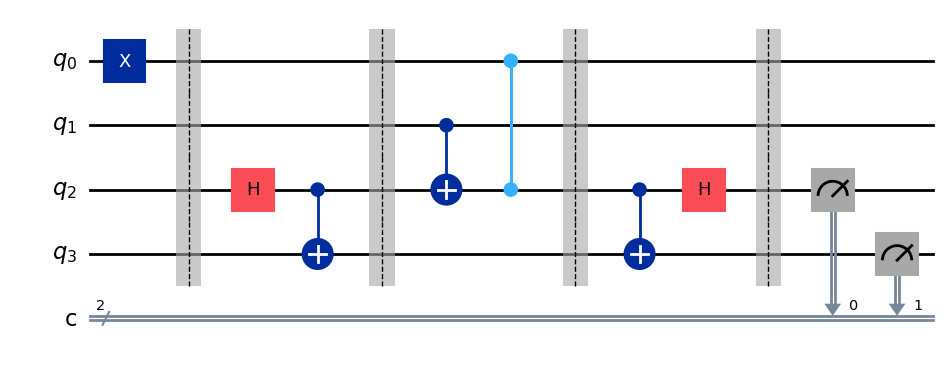

In [13]:
qc = QuantumCircuit(
    4, # 4 кубита
    2  # 2 классических бита (для измерения в конце)
)

# Кодируем сообщение первыми двумя кубитами
if (DIGIT_TO_ENCODE & 0b01):
    qc.x(0)
if (DIGIT_TO_ENCODE & 0b10):
    qc.x(1)
qc.barrier()

# Вводим кубит Боба и транспортный кубит в состояние квантовой запутанности
qc.h(2)
qc.cx(2, 3)
qc.barrier()

# Алиса передаёт транспортный кубит Бобу
qc.cx(1, 2)
qc.cz(0, 2)
qc.barrier()

# Боб расшифровывает переданный транспортный кубит
qc.cx(2, 3)
qc.h(2)
qc.barrier()

# Вуаля, всего одним кубитом мы передали число длиной два классических бита
qc.measure(2, 0)
qc.measure(3, 1)

qc.draw("mpl")

In [14]:
simulator = AerSimulator()

compiled_circuit = transpile(qc, simulator)

job = simulator.run(compiled_circuit, shots=1024)
result = job.result()
counts = result.get_counts(compiled_circuit)

print("Результат измерения:", counts)

Результат измерения: {'01': 1024}


# Версия от гопоты

Тут всего два кубита вместо четырёх

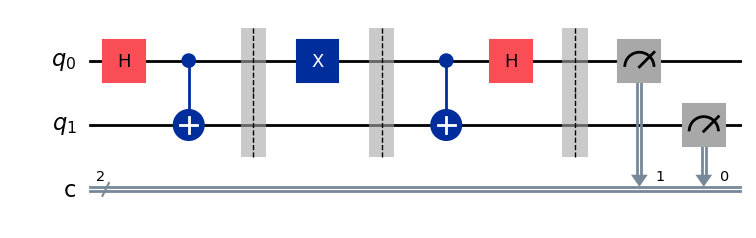

In [15]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

qc = QuantumCircuit(
    2, # 2 кубита
    2  # 2 классических бита (для измерения в конце)
)

# Создаём состояние квантовой запутанности между 1 и 2 кубитами
qc.h(0)
qc.cx(0, 1)
qc.barrier()

# Алиса кодирует два классических бита в первый кубит
if DIGIT_TO_ENCODE & 0b01:
    qc.x(0)
if DIGIT_TO_ENCODE & 0b10:
    qc.z(0)
qc.barrier()

# --- Смертельный номер, Алиса отправляет Бобу первый кубит! ---

# Боб декодирует полученный от Алисы кубит
qc.cx(0, 1)
qc.h(0)
qc.barrier()

# Наконец, Боб измеряет первый и затем второй кубиты
qc.measure(0, 1)
qc.measure(1, 0)

qc.draw("mpl")

In [16]:
simulator = AerSimulator()

compiled_circuit = transpile(qc, simulator)

job = simulator.run(compiled_circuit, shots=1024)
result = job.result()
counts = result.get_counts(compiled_circuit)

print("Результат измерения:", counts)

Результат измерения: {'01': 1024}


# В чём разница? (объяснение от гопоты)

## 1. Структура кубитов

#### В первой схеме (4 кубита)

Ты фактически моделируешь:

* кубиты `0`, `1` — **классические биты Алисы**, которые она хочет передать, кодируя их в операторах X и Z;
* кубит `2` — **транспортный кубит** (тот самый один физический кубит, который летит к Бобу);
* кубит `3` — **кубит Боба**, заранее запутанный с `2`.

То есть ты строишь **полный физический сценарий “Алиса имеет данные → транспортный кубит → Боб имеет свою половину запутанной пары”**.

Схема ближе к реальному распределённому протоколу.


#### Во второй схеме (2 кубита)

Ты используешь **только два кубита**:

* кубит `0` — кубит Алисы (который она отправляет),
* кубит `1` — кубит Боба.

Никаких отдельных «данных» и «транспортных» кубитов — Алиса кодирует сообщение непосредственно на своей половине запутанной пары.

Это *каноническая схема сверхплотного кодирования*, как её обычно дают в учебниках.


## 2. Разница в способе кодирования

#### В первой схеме

Ты кодируешь:

* X на кубите 0,
* X на кубите 1,

а затем переносишь их влияние на транспортный кубит через операции:

```python
qc.cx(1, 2)
qc.cz(0, 2)
```

Это фактически означает:
**сначала кодируем сообщение на отдельных классических кубитах Алисы, а затем “загружаем” его в транспортный кубит через управляемые гейты.**

То есть кодирование происходит *побочно* — через перенос состояния данных.


#### Во второй схеме

Кодирование делается **непосредственно** на первом кубите пары (кубит Алисы):

```python
qc.x(0)   # кодирует младший бит
qc.z(0)   # кодирует старший бит
```

Это и есть стандартный протокол:
**Алиса применяет X и Z прямо к своей половине ЭПР-пары.**

Никаких промежуточных кубитов нет.


## 3. Разница в “физичности” протокола

Первая схема:

* имитирует четыре разные физические сущности;
* моделирует реальную передачу информации *через цепочку гейтов*;
* более низкоуровневая и детализированная.

Вторая схема:

* строго следует учебному алгоритму;
* минимальна;
* не моделирует два кубита данных, а кодирует всё прямо в выполняемых гейтах.


## 4. Разница в количестве необходимой запутанности

Обе схемы используют **одну ЭПР-пару**.

* В первой это кубиты (2, 3).
* Во второй это (0, 1).

Но в первой схема выглядит “больше”, потому что ты держишь два дополнительный кубита для хранения классических данных.

## **Итог**

**Отличается не только способ кодирования, но и само представление протокола:**

* первая схема — *расширенная*, с полной моделировкой распределённой системы и отдельными кубитами для данных Алисы и транспортного канала;
* вторая — *каноническая*, минимальная, напрямую соответствующая стандартному протоколу сверхплотного кодирования.

Обе схемы работают одинаково, но в первой кодирование выполняется в два шага (запись на отдельные кубиты, перенос на транспортный кубит), в то время как во второй кодирование делается сразу на кубите Алисы.